
### Stage 1

For the project we need to analyze the metadata and the images.

1. We need to create an sql database for the tables of data.
2. Data with lacking age of the pacient would be still useful for classification but will not be taken into account in statistical analysis.
3. We need algorithm for detecting and selecting the skin pathologies from the pictures.


### Stage 2

1. Run the selection algorithm for all of the examples an create separate table with those values
2. Create simple convulutional neural network as a test (proof of concept that it could be done)


In [1]:
using CSV
using DataFrames
using Statistics
using Plots
using Colors
using Distributions
using Images
#using FileIO

In [2]:
metadata = CSV.read("HAM10000_metadata.csv", DataFrame)

,lesion_id,image_id,dx,dx_type,age,sex,localization
,String,String,String,String,Float64?,String,String
1,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
2,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
4,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
5,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
6,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
7,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
8,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
9,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back


In [3]:
age_clean = [age for age in metadata[:, :age] if typeof(age)==Float64]
age_deviation = std(age_clean)
age_mean      = mean(age_clean)
age_median    = median(age_clean)

# true - cancerous
# false - non-cancerous
mutation_types = Dict(
    "bkl"   => false,  # Benign keratosis-like lesions 
    "nv"    => false,  # Melanocytic nevi
    "df"    => false,  # Dermatofibroma
    "mel"   => true,   # Melanoma
    "vasc"  => false,  # Vascular lesions
    "bcc"   => true,   # Basal cell carcinoma
    "akiec" => true    # Actinic keratoses and intaepithelial carcinoma / Bowen's diesease
)

display(age_deviation)
display(age_mean)
display(age_median)
display(mutation_types)

16.96861369249536

51.863828077927295

50.0

Dict{String, Bool} with 7 entries:
  "df"    => 0
  "nv"    => 0
  "vasc"  => 0
  "mel"   => 1
  "akiec" => 1
  "bcc"   => 1
  "bkl"   => 0

Here we have the histogram of color distribution along all of the images.
Interesting thing to notice is the little distortion near the darker colors(left side)

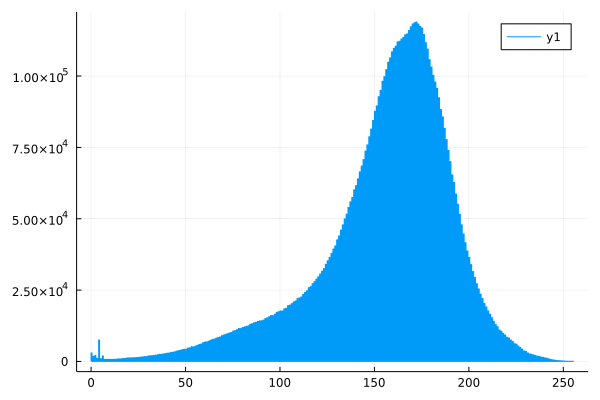

In [4]:
small_img_gray_data = CSV.read("./datasets/HAM10000/hmnist_28_28_L.csv", DataFrame)
# display(Array(small_img_gray_data[5,:]))
big_img_gray_data = []
for i in 1:9999
    append!(big_img_gray_data, Array(small_img_gray_data[i, :]))
end
small_img_gray_data = Array(small_img_gray_data[33, :])
image_color_histogram = histogram(big_img_gray_data)
# small_img_gray_data = reshape(small_img_gray_data[1:end-1], (28,28))

# image_plot = heatmap(small_img_gray_data, color=:grays)

Exemplary picture of some abnorormality of skin.
Clean image with highly visible abnormality.

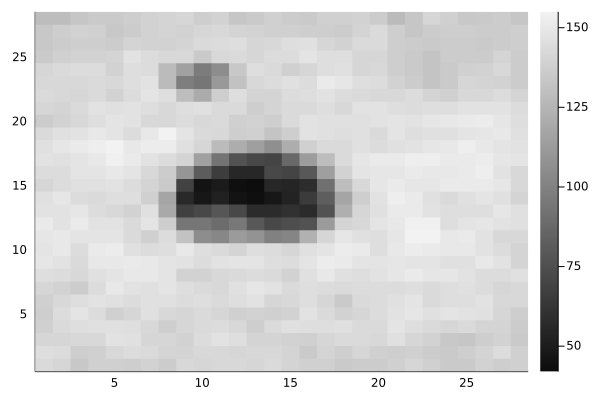

In [5]:
small_img_gray_data = CSV.read("./datasets/HAM10000/hmnist_28_28_L.csv", DataFrame)
# display(Array(small_img_gray_data[5,:]))
# big_img_gray_data = []
# for i in 2500:3500
#     append!(big_img_gray_data, Array(small_img_gray_data[i, :]))
# # end
small_img_gray_data = Array(small_img_gray_data[55, :])
image_color_histogram = histogram(big_img_gray_data)
small_img_gray_data = reshape(small_img_gray_data[1:end-1], (28,28))

image_plot = heatmap(small_img_gray_data, color=:grays)

In [6]:
include("FCM.jl")

function gauss(from, to, σ, μ, step=1)
    range_result = []

    for i in from:step:to-1
        append!(range_result, (1 / (σ*sqrt(2π)))*ℯ^(-0.5*((i-μ)/σ)^2))
    end
    
    return range_result
end

gauss (generic function with 2 methods)

The cluster anlaysis for the clean image from above

2×784 Matrix{Int64}:
 143  145  141  138  137  138  141  145  …  140  136  136  136  137  137  133
 143  145  141  138  137  138  141  145     140  136  136  136  137  137  133

2×784 Matrix{Float64}:
 7.93247e-15  1.89855e-10  6.61456e-12  …  6.61045e-8  6.61045e-8  3.94783e-6
 1.0          1.0          1.0             1.0         1.0         0.999996

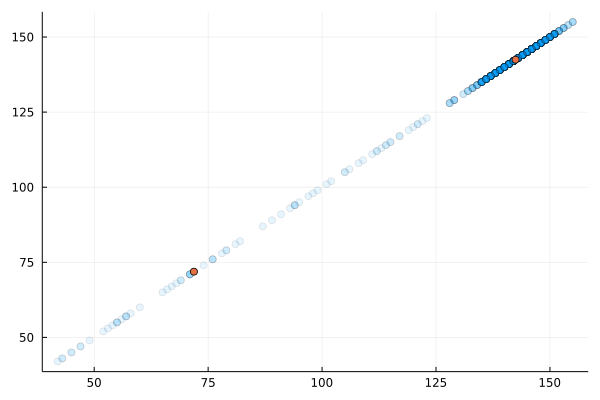

In [7]:
small_img_gray_data = CSV.read("./datasets/HAM10000/hmnist_28_28_L.csv", DataFrame)
small_img_gray_data = [i for i in Array(small_img_gray_data[55, :])[1:end-1]]
# #histogram(small_img_gray_data)
# data = reshape(small_img_gray_data, length(small_img_gray_data), 1)
data = rotl90(hcat(small_img_gray_data, small_img_gray_data))
display(data)
# highest_value = maximum(small_img_gray_data)

(U, V) = fuzzy_c_means(data, 2, 1.3)

scatter(data[1,:], data[2,:], alpha=0.1, legend=false)
scatter!(V[1, :], V[2,:], alpha=1)

Above clusters are appropriate for the given picture as there is only one dark spot in the picture.
Now we will load some, less ideal picture.

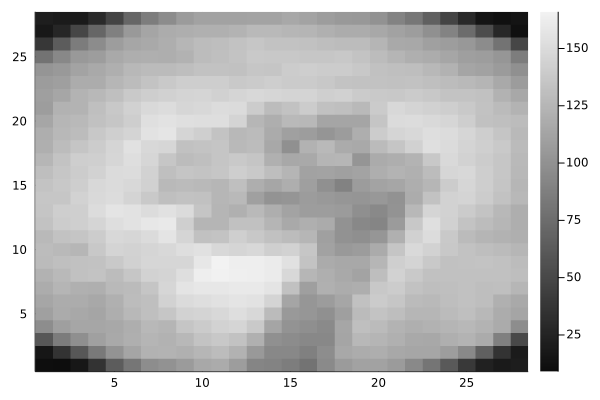

In [8]:
small_img_gray_data = CSV.read("./datasets/HAM10000/hmnist_28_28_L.csv", DataFrame)
# display(Array(small_img_gray_data[5,:]))
# big_img_gray_data = []
# for i in 2500:3500
#     append!(big_img_gray_data, Array(small_img_gray_data[i, :]))
# # end
small_img_gray_data = Array(small_img_gray_data[92, :])
image_color_histogram = histogram(big_img_gray_data)
small_img_gray_data = reshape(small_img_gray_data[1:end-1], (28,28))

image_plot = heatmap(small_img_gray_data, color=:grays)

2×784 Matrix{Int64}:
 10  15  60  97  110  114  118  122  …  123  115  107  99  86  48  11  14
 10  15  60  97  110  114  118  122     123  115  107  99  86  48  11  14

2×784 Matrix{Float64}:
 0.000616722  0.000330196  4.85813e-6  0.94342    …  0.000549067  0.000377628
 0.999383     0.99967      0.999995    0.0565802     0.999451     0.999622

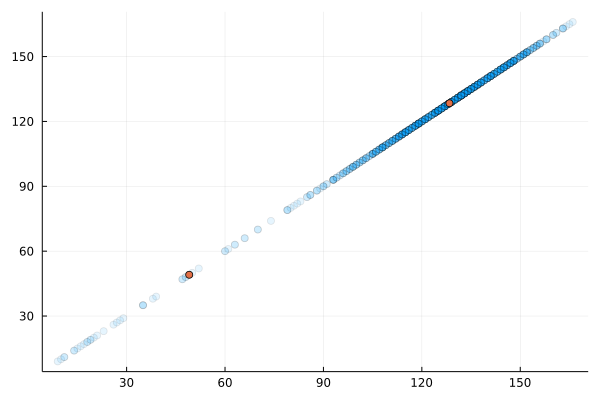

In [9]:
small_img_gray_data = CSV.read("./datasets/HAM10000/hmnist_28_28_L.csv", DataFrame)
small_img_gray_data = [i for i in Array(small_img_gray_data[92, :])[1:end-1]]
# #histogram(small_img_gray_data)
# data = reshape(small_img_gray_data, length(small_img_gray_data), 1)
data = rotl90(hcat(small_img_gray_data, small_img_gray_data))
display(data)
# highest_value = maximum(small_img_gray_data)

(U, V) = fuzzy_c_means(data, 2, 1.3)

scatter(data[1,:], data[2,:], alpha=0.1, legend=false)
scatter!(V[1, :], V[2,:], alpha=1)

In [10]:
# image_name = "ISIC_0024561.jpg"
# image = load("datasets\\HAM10000\\HAM10000_images_part_1\\$image_name")
# println(image)